In [11]:
import pandas as pd
import eeg
from eeg import unix_to_localdate, unix_to_period, get_signal_quality_summary
import datetime
import scipy.stats
import scipy.fftpack
import numpy as np
import matplotlib.pyplot as plt
import copy
from sklearn.linear_model import LinearRegression
import seaborn as sns


files = eeg.extractBundledEEG("../../scripts/data/")
files.addMeta("../../scripts/data/eeg-restingstate/events.csv","timeofday")
files.prune()
# files.mergeTagsWithRegex("[cC]lose","Eyes Closed")
files.categories
dataAgg = dict()

bands_ordered = ["delta", "theta", "alpha", "beta", "gamma"]

def load_session_epochs(files: dict, _on: set, _channels: list = [],qualityCutoffFilter: int = 0, epochSize: int = -1):
    """
    Takes a session of EEG data and the recordings concerned with and outputs filtered epochs
    qualityCutoffFilter: percentage of time electrode data is marked as "good" or "great" required for it to be included in output and analyticsl, 0 capture everything
    epochSize: epochlength in seconds
    _on: recordings to perform on, ex powerByBand or rawBrainwave

    returns dictionary of dataframes with the recordings specified in _on with epoched and filtered data
    """
    # Best channels are usually: CP3, CP4, PO3, PO4

    # NOTE: unixTimestamps are int/seconds but samples more often than 1Hz,
    #       so several rows per timestamp and missing sub-second resolution.

    _on+=["signalQuality","powerByBand"]
    
    _on = set(_on)
    on = dict()
    for x in _on:
        if str(files[x]).endswith(".csv"):
            on[x] = pd.read_csv(files[x])
        else:
            on[x] = pd.read_json(files[x])

    for x in on:
        on[x].rename(columns={"timestamp": "unixTimestamp"},inplace=True)
        on[x]["epoch"] = on[x]["unixTimestamp"].copy(deep=True)
        if str(on[x]["epoch"].dtype) == "datetime64[ns]":
            on[x]["epoch"] = on[x]["epoch"].astype(int) / 10**9
    
        try:
            on[x]["unixTimestamp"] =  pd.to_datetime(on[x]["unixTimestamp"], unit="s")
        except:

            on[x]["epoch"] = np.floor(on[x]["epoch"] / 1000)
            on[x]["unixTimestamp"] =  pd.to_datetime(on[x]["unixTimestamp"], unit="ms")

        on[x].set_index("unixTimestamp",drop=False, inplace=True)

    if epochSize == -1: epochSize = (on["signalQuality"].index[on["signalQuality"].shape[0]-1]-on["signalQuality"].index[0]).seconds
    for x in on: 
        on[x]["epoch"] = epochSize*np.floor(on[x]["epoch"]/epochSize)
        on[x] = on[x].set_index(["epoch","unixTimestamp"])

    df_sigQ = on["signalQuality"]


    channels, bands = zip(*[c.split("_") for c in on["powerByBand"].columns[1:-2]])
    channels, bands = list(set(channels)), list(set(bands))

    onChan = {} # generate dictionary that maps channels to related columns
    for df in on:
        onChan[df] = {x: [y for y in on[df].columns if x in y] for x in channels}

    if _channels != []:
        removed = [x for x in channels if x not in _channels]
        for x in on:
            on[x].drop([col for col in on[x].columns if len([r for r in removed if r in col])>0], axis=1)
        channels = _channels

    onChan = {}
    for df in on:
        onChan[df] = {x: [y for y in on[df].columns if x in y] for x in channels}
        onChan[df] = {x : onChan[df][x] for x in onChan[df] if len(onChan[df][x])>0}

    for x in onChan["powerByBand"]:
        maparr = on["powerByBand"][onChan["powerByBand"][x][2]]>20
        on["powerByBand"].loc[maparr,onChan["powerByBand"][x]] = pd.NA
        


    goodEpochStampsPerChan = {x: set() for x in channels}
    goodEpochStamps = {}
    # for x in [onChan["signalQuality"][x][1] for x in onChan["signalQuality"]]:
    #     print(df_sigQ.groupby(level=[0])[x].value_counts())
    #     break
    #     # for y in df_sigQ.groupby(level=[0])[x].value_counts():
            
    
        

    for x in set(df_sigQ.index.get_level_values(0)):
        sigSamp = df_sigQ.loc[x,:]
        for channel in channels:
            col = channel + "_status"
            channel_states = sigSamp[col].value_counts()
            no_of_okay_samples = 0
            if 'good' in channel_states:
                no_of_okay_samples += channel_states['good']
            if 'great' in channel_states:
                no_of_okay_samples += channel_states['great']

            percentage_good = no_of_okay_samples / sigSamp.shape[0]
            if percentage_good>=qualityCutoffFilter:
                if x not in goodEpochStamps: goodEpochStamps[x] = [channel]
                else: goodEpochStamps[x].append(channel)

                goodEpochStampsPerChan[channel].add(x)

    goodEpochSerial = {}
    for i,x in enumerate(goodEpochStamps.keys()):
        goodEpochSerial[x] = i

    
    for x in on:
        on[x]["_epoch"] = on[x].index.get_level_values(0)
        if x != "signalQuality":
            for channel in onChan[x]:
                badStamps = set(on[x]["_epoch"]).difference(goodEpochStampsPerChan[channel])
                if len(badStamps) != 0:
                    on[x].loc[list(badStamps),onChan[x][channel]] = pd.NA


        badStamps = set(on[x]["_epoch"]).difference(goodEpochSerial.keys())
        on[x].loc[list(badStamps),"_epoch"] = pd.NA
        on[x]["_epoch"] = on[x]["_epoch"].replace(goodEpochSerial)


        # print(on[x])

   

    for x in on:
        on[x].reset_index(inplace=True)
        on[x].drop(columns=["epoch"],inplace=True)
        on[x].rename(columns={"_epoch":"epoch"},inplace=True)
        on[x] = on[x].set_index(["epoch","unixTimestamp"])

    # on["signalQuality"].to_csv("EpochValidate.csv")
        
    return on

def load_session_summery(files: dict, _channels: list = [], qualityCutoffFilter: int = 0, epochSize: int = -1, returnEpoched = False, debug=False) -> dict: # summery or epoch return
    """
    Takes a session of EEG data, computes some metrics, and returns them.
    qualityCutoffFilter: percentage of time electrode data is marked as "good" or "great" required for it to be included in output and analyticsl, 0 capture everything
    epochSize: the window to sample on (seconds)
    returnEpoched: if False, returns average over all the valid epoch, if true summary per epoch

    Potential metrics:
     - average power by band
     - average power by channel
     - relative power by band
     - average focus/calm score
    """
    # Best channels are usually: CP3, CP4, PO3, PO4

    # NOTE: unixTimestamps are int/seconds but samples more often than 1Hz,
    #       so several rows per timestamp and missing sub-second resolution.

    epochs = load_session_epochs(files,_on=["powerByBand","calm","focus","signalQuality"], _channels = _channels ,qualityCutoffFilter=qualityCutoffFilter,epochSize=epochSize)

    channels, bands = zip(*[c.split("_") for c in epochs["powerByBand"].columns[1:-1]])
    channels, bands = list(set(channels)), list(set(bands))

    if _channels!=[]:
        channels = _channels

    removedChannels = []

    for x in channels: 
        # print(temporalFilter[x].value_counts())
        #  just check that there's at least some value in the channel
        validEpochs = ~epochs["powerByBand"][x+"_delta"].isna()
        if True not in validEpochs.value_counts():
            removedChannels.append(x)
            channels.remove(x)
        else:
            percentLost = 1-(validEpochs.value_counts()[True]/validEpochs.shape[0])
            if percentLost > .4 and debug:
                print(f"{int(percentLost*100)}% of {x} Pruned for lack of quality")
            if percentLost>.9:
                removedChannels.append(x)
                channels.remove(x)

    epochStruct = {"timestamp": None,
            "local_date": None,
            "local_timeofday": None,
            "duration": None,
            "avg_power_per_channel_by_band": dict(),
            "avg_power_by_band": dict(),
            "avg_power_by_channel": dict(),
            "avg_calm_score": None,
            "avg_focus_score": None,
            "time_spent_calm": None,
            "time_spent_focused": None,
            "relative_power": None,
            "signal_quality": None
            }

    epochReturnStruct = {}

    if not returnEpoched:
        for x in epochs:
            epochs[x]=epochs[x].reset_index()
            epochs[x]["epoch"]=0
            epochs[x] = epochs[x].set_index(["epoch","unixTimestamp"]).sort_index()

    for epochInd in set(list(zip(*epochs["powerByBand"].index))[0]):
        if pd.isna(epochInd): continue
        pbbEpochDf = epochs["powerByBand"].loc[epochInd,:]
        epochTemp = copy.deepcopy(epochStruct)

        df = pd.DataFrame(index=pbbEpochDf.index) 
        for channel in channels:
            bands_for_channel = [c for c in pbbEpochDf.columns if c.startswith(channel)]
            df[channel] = pbbEpochDf[bands_for_channel].mean(axis=1)
        epochTemp["avg_power_by_channel"] = dict(df.mean()[channels])
        df = pd.DataFrame(index=pbbEpochDf.index)

        for band in bands:
            channels_with_band = [c for c in pbbEpochDf.columns if c.endswith(band) and c.split("_")[0] not in removedChannels]
            df[band] = pbbEpochDf[channels_with_band].mean(axis=1)

        epochTemp["avg_power_by_band"] = dict(df.mean()[bands_ordered])
        epochTemp["avg_power_per_channel_by_band"] = {channel: {band: pbbEpochDf[channel + "_" + band].mean() for band in bands}
                    for channel in channels}
        
        epochTemp["timestamp"] = int(pbbEpochDf.index[0].timestamp())
        epochTemp["duration"] =  pbbEpochDf.index[-1] - pbbEpochDf.index[0]
        epochTemp["local_date"] = unix_to_localdate(epochTemp["timestamp"])
        epochTemp["local_timeofday"] = unix_to_period(epochTemp["timestamp"])


        if epochInd in epochs["calm"].index.get_level_values(0):
            df_calm = epochs["calm"].loc[epochInd,:]
            epochTemp["avg_calm_score"] = df_calm["probability"].mean()
            epochTemp["time_spent_calm"] = (df_calm["probability"] > 0.3).sum() / len(df_calm)

        if epochInd in epochs["focus"].index.get_level_values(0):
            df_focus = epochs["focus"].loc[epochInd,:]
            epochTemp["avg_focus_score"] = df_focus["probability"].mean()
            epochTemp["time_spent_focused"] = (df_focus["probability"] > 0.3).sum() / len(df_focus)


        relativePower = dict()
        for channel in channels:
            totalPower = 0
            for band in bands:
                totalPower+=epochTemp["avg_power_per_channel_by_band"][channel][band]
            for band in bands:
                if channel not in relativePower: relativePower[channel] = dict()
                relativePower[channel][band] = epochTemp["avg_power_per_channel_by_band"][channel][band]/totalPower

        epochTemp["relative_power"] = relativePower
        epochTemp["signal_quality"] = get_signal_quality_summary(epochs["signalQuality"].loc[epochInd,:])



        epochReturnStruct[epochInd] = epochTemp

    if not returnEpoched: epochReturnStruct = epochReturnStruct[0]

    return epochReturnStruct


class analysisEngine():
    def __init__(self,fileBundles:dict,epochSize=5):
        """
        Generates basic analytics for recording groups
        
        fileBundles: {recordingsTagName:[set of recordingIds], tagName: ....} 
        
        """
        self.fileBundles = fileBundles
        self.fileBundleSummeries = {x:[] for x in self.fileBundles}

        for x in self.fileBundles:
            sum = 0
            for y in self.fileBundles[x]:
                self.fileBundleSummeries[x].append(load_session_summery(self.fileBundles[x][y],qualityCutoffFilter=.95,epochSize=epochSize,returnEpoched=True,debug=False))
                sum += len(self.fileBundleSummeries[x][-1])
            print(f"{x} {len(self.fileBundles[x])} Recording Sessions Found, {sum} Epochs Extracted")

    def distributionVetting(self):
        self.accumulatedPowerBands = {x:dict() for x in self.fileBundles}
        for x in self.fileBundles: # Basic sanity checks of distributions
            for y in self.fileBundleSummeries[x]:
                for epoch in y:
                    for band in y[epoch]["avg_power_by_band"]:
                        if band not in self.accumulatedPowerBands [x]: self.accumulatedPowerBands [x][band] = []
                        self.accumulatedPowerBands [x][band].append(y[epoch]["avg_power_by_band"][band])

        
        count = 0
        for band in bands_ordered:
            count+=1
            for x in self.fileBundles:
                plt.subplot(5, 1, count)
                plt.hist(self.accumulatedPowerBands [x][band],alpha=0.5,bins=160,label=x)
                
            plt.title(f'{band} Epoch Averages')

            plt.legend()
            plt.xlabel('uV')
            plt.ylabel('Count')
            plt.grid(True)
            plt.show()

    def basicComparisons(self):
        accumatedPowerBandStats = {x:dict() for x in self.fileBundles}
        accumatedPowerBandErrors = {x:dict() for x in self.fileBundles}

        for x in self.accumulatedPowerBands: # avgs with error bars
            for band in self.accumulatedPowerBands[x]:
                accumatedPowerBandStats[x][band] = np.nanmean(np.array(self.accumulatedPowerBands[x][band]))
                # print(np.array(accumulatedPowerBands[x][band]))
                accumatedPowerBandErrors[x][band] = np.nanstd(np.array(self.accumulatedPowerBands[x][band])) # hilarous error bars on everything scaled to make visable
            
            
            
        fig, ax = plt.subplots()
        bar_width = .3
        currentBarDist = bar_width
        figs = {x:0 for x in self.fileBundles}
        index = np.arange(5)
        for x in accumatedPowerBandStats:
            print(x,accumatedPowerBandStats[x])
            ax.bar(index+currentBarDist,list(accumatedPowerBandStats[x].values()), bar_width,
                        label=x,yerr=list(accumatedPowerBandErrors[x].values()))
            currentBarDist+=bar_width

        ax.set_xticks(index + bar_width / 2)
        ax.set_xticklabels(accumatedPowerBandStats[x].keys())
        ax.set_xlabel('Band')
        ax.set_ylabel('Average uV')
        ax.set_title('Average uV by Band')
        ax.legend()

        plt.show()

analysis = analysisEngine({"morning":files.extractByTags("morning"),"evening":files.extractByTags("evening")},epochSize=10)

1674926196 Meta available but no associated recordings
morning 13 Recording Sessions Found, 522 Epochs Extracted
evening 12 Recording Sessions Found, 588 Epochs Extracted


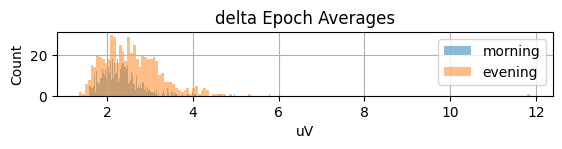

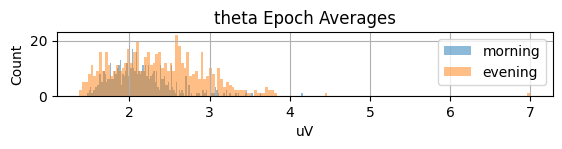

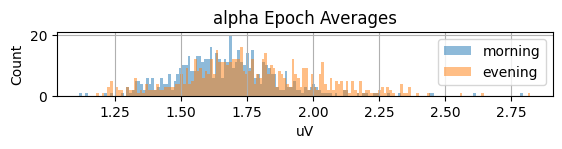

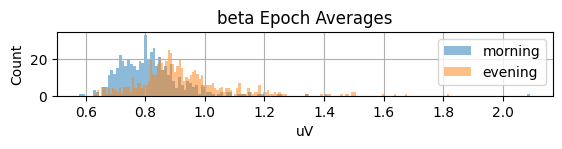

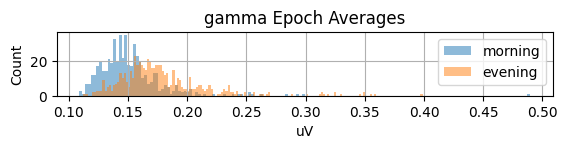

In [12]:
analysis.distributionVetting()

morning {'delta': 2.3397861571663965, 'theta': 2.1441864674246105, 'alpha': 1.671427547431554, 'beta': 0.8197151378804658, 'gamma': 0.1519768458164134}
evening {'delta': 2.5987869996010375, 'theta': 2.3573850448715734, 'alpha': 1.7671066608905104, 'beta': 0.9226544556882644, 'gamma': 0.17820280141422343}


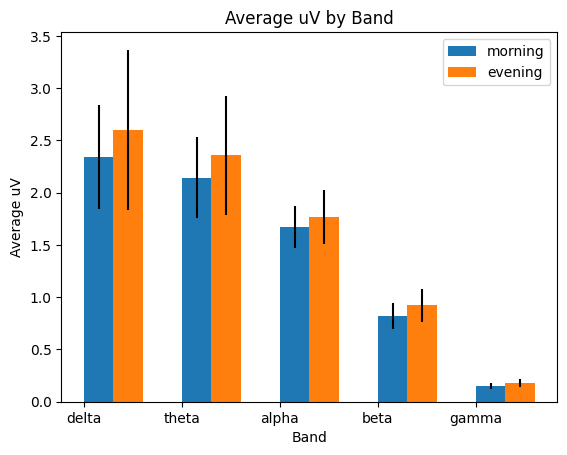

In [13]:
analysis.basicComparisons()


['Mood', 'Mental State']
Intercept: -0.4921285770904793
Slope: 0.2724237527533933
Fit: 0.3732540408252587


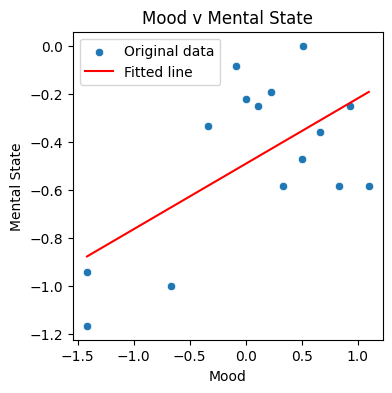


['Mood', 'Physical Ability']
Intercept: -0.06875188600491686
Slope: 0.04035908396613275
Fit: 0.008726766840045586


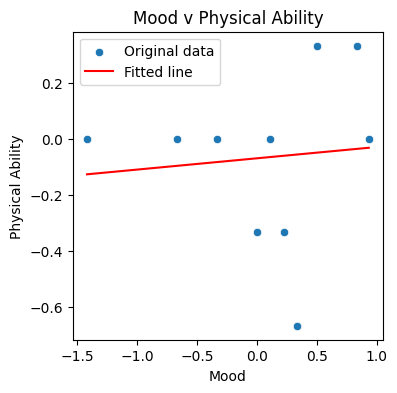


['Mood', 'Diet Mishaps']
Intercept: -1.5933272437699082
Slope: -0.095868465430017
Fit: 0.06361020377797


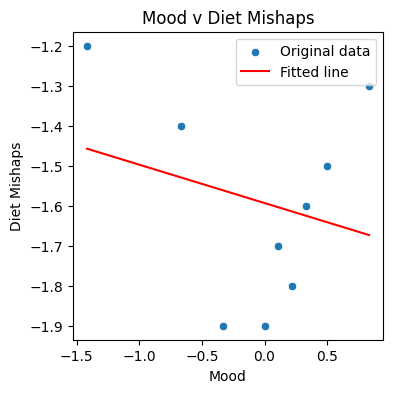


['Mental State', 'Physical Ability']
Intercept: -0.15700578338590954
Slope: -0.18690851735015765
Fit: 0.032381080856716316


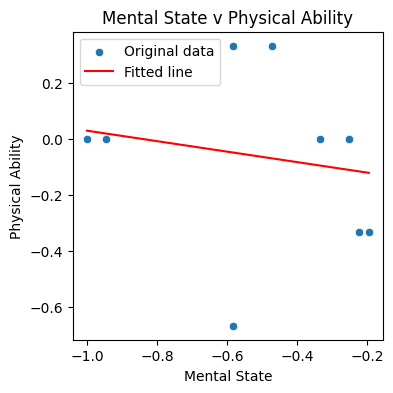


['Mental State', 'Diet Mishaps']
Intercept: -1.9545109211775875
Slope: -0.7179487179487175
Fit: 0.7038712921065864


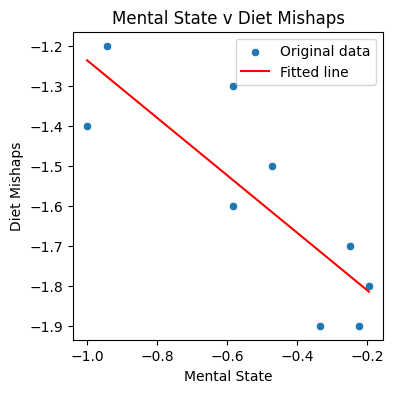


['Physical Ability', 'Diet Mishaps']
Intercept: -1.561764705882353
Slope: 0.3661764705882354
Fit: 0.2128336628769154


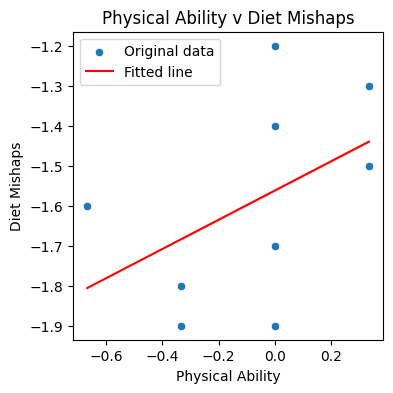

In [15]:
prompts = pd.read_csv("./test_data/responses_1686523226.csv")
prompts["triggerTimestamp"] =  pd.to_datetime(prompts["triggerTimestamp"], unit="ms")
prompts["responseTimestamp"] =  pd.to_datetime(prompts["responseTimestamp"], unit="ms")
uuidMap = {"7526b4ca371d4e715c0f972d5d37f610c667b2a3dd042fdf8d42c5349fc14b6b":"Mental State","afb48d44df6ce7cc15dc1bcac2f79e1721007751810fd8f94b16b04d02905b19":"Physical Ability",
           "95296077e31c258cfdc64cad48aa3615170cc9f6e05fdad98f11bd767da418a7":"Diet Mishaps","2066cbe5f2c51400491651532805b5cb511ce3d1487e35910adf50e76a1123e0":"Mood"}
prompts["promptUuid"] = prompts["promptUuid"].replace(uuidMap)

rollingAverageWindow = {"Physical Ability":3,"Mental State":3,"Diet Mishaps":5,"Mood":3}

prompts.set_index("responseTimestamp",inplace=True,drop=False)
prompts.sort_index()

scaleMap = {"Neutral":0,"Tired":-1,"Energetic":1,"Foggy":-2,
         "Light Exersize Capable":0,"Walking is Laborous":-1,"Heavy Exersize Capable":1,
         "Emptiness":-3,"Despair":-2,"Sad":-1,"Content":1,"Happy":2,"Elated":3,
         "None":0,"Subtle":-1,"Egregious(cheese, milk, gluten) ":-2
         }
prompts["value"] = prompts["value"].replace(scaleMap)

relationshipPerm = []
Types = list(set(prompts["promptUuid"]))
for i,x in enumerate(Types):
    for y in Types[i+1:]:
        relationshipPerm.append([x,y])

prompts["responseTimestamps"] = prompts["responseTimestamp"].dt.round("D")

grouped = prompts.groupby(by=["responseTimestamps","promptUuid"]).mean()

for x in relationshipPerm:
    df = pd.DataFrame()
    df[x[0]] = grouped.xs(x[0], level=1, drop_level=False).droplevel(1)["value"].rolling(window=rollingAverageWindow[x[0]]).mean()
    df[x[1]] = grouped.xs(x[1], level=1, drop_level=False).droplevel(1)["value"].rolling(window=rollingAverageWindow[x[1]]).mean()

    df.dropna(axis=0, how='any',inplace=True)
    model = LinearRegression()

    # Fit the model
    X = df[x[0]].values.reshape(-1, 1)  # Features
    y = df[x[1]]  # Target
    model.fit(X, y)

    # Print the coefficients
    print(f"\n{x}")
    print('Intercept:', model.intercept_)
    print('Slope:', model.coef_[0])
    print('Fit:', model.score(X,y))


    # Predict the values
    df['predicted'] = model.predict(X)

    # Plot the original data and the regression line
    plt.figure(figsize=(4, 4))
    sns.scatterplot(x=x[0], y=x[1], data=df, label='Original data')
    sns.lineplot(x=x[0], y='predicted', data=df, color='red', label='Fitted line')
    plt.xlabel(x[0])
    plt.ylabel(x[1])
    plt.title(f"{x[0]} v {x[1]}")
    plt.legend()
    plt.show()


[[0.21228424]
 [0.27552516]
 [0.85325061]
 [0.00848945]
 [0.24165143]
 [0.25026864]
 [0.1531188 ]
 [0.46872579]
 [0.16279415]
 [0.46656061]
 [0.86163973]
 [0.12121098]
 [0.51019787]
 [0.03996467]
 [0.65930976]
 [0.33581882]
 [0.67043735]
 [0.09539589]
 [0.45638383]
 [0.58656318]
 [0.0694579 ]
 [0.64893679]
 [0.93332942]
 [0.59470945]
 [0.02800915]
 [0.03279743]
 [0.21893397]
 [0.84373314]
 [0.6959352 ]
 [0.49919694]
 [0.68761349]
 [0.35493045]
 [0.77059316]
 [0.16736767]
 [0.55019899]
 [0.6249143 ]
 [0.63833809]
 [0.74014678]
 [0.69187541]
 [0.84430359]
 [0.14064988]
 [0.43661141]
 [0.07427398]
 [0.69013295]
 [0.95428292]
 [0.20463613]
 [0.94360176]
 [0.4617674 ]
 [0.43671486]
 [0.72035845]
 [0.67734084]
 [0.43310656]
 [0.48073606]
 [0.29848795]
 [0.07788077]
 [0.15701412]
 [0.3609308 ]
 [0.30966658]
 [0.06307   ]
 [0.41365713]
 [0.1369482 ]
 [0.61997212]
 [0.77638142]
 [0.56883811]
 [0.95678812]
 [0.82390579]
 [0.91707301]
 [0.84080262]
 [0.50982387]
 [0.86022235]
 [0.52939914]
 [0.49

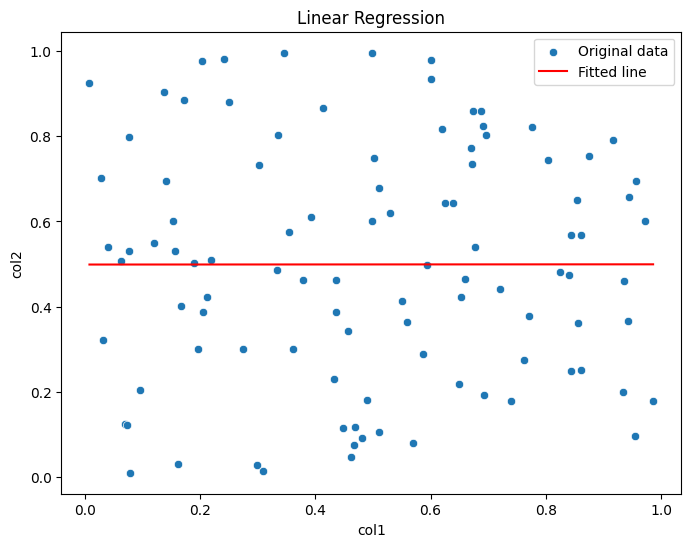

In [8]:
dataAgg = {k : { x : [{y+"_"+z : dataAgg[k][x][y][z] for z in dataAgg[k][x][y]} for y in dataAgg[k][x]] for x in dataAgg[k]} for k in dataAgg}
for x in dataAgg:
    for y in dataAgg[x]:
        accumulated = {}
        for z in dataAgg[x][y]:
            accumulated.update(z)
        dataAgg[x][y] = accumulated

Simple Aggregated Trials

In [74]:
morning = pd.DataFrame.from_dict(dataAgg["morning"],orient="index")
morningAgg = pd.DataFrame()
chan, band = zip(*[x.split("_") for x in morning.columns])
chan = set(chan)
band = set(band)
for x in band:
    morningAgg[x] = morning[[col for col in morning.columns if x in col]].mean(axis=1)

# print("std",morning.std(axis=1, numeric_only=True))
# print("mean",morning.mean(axis=1, numeric_only=True))

print("std",morningAgg.std(axis=0, numeric_only=True))
print("mean",morningAgg.mean(axis=0, numeric_only=True))

morningStats = {"std":dict(morningAgg.std(axis=0, numeric_only=True)),"mean":dict(morningAgg.mean(axis=0, numeric_only=True))}


ValueError: not enough values to unpack (expected 2, got 1)

In [10]:
evening = pd.DataFrame.from_dict(dataAgg["evening"],orient="index")

eveningAgg = pd.DataFrame()
chan, band = zip(*[x.split("_") for x in evening.columns])
chan = set(chan)
band = set(band)

for x in band:
    eveningAgg[x] = evening[[col for col in evening.columns if x in col]].mean(axis=1)

# print("std",evening.std(axis=0, numeric_only=True))
#print("mean",evening.mean(axis=0, numeric_only=True))
print("std",eveningAgg.std(axis=0, numeric_only=True))
print("mean",eveningAgg.mean(axis=0, numeric_only=True))

eveningStats = {"std":dict(eveningAgg.std(axis=0, numeric_only=True)),"mean":dict(eveningAgg.mean(axis=0, numeric_only=True))}
eveningStats

std gamma    0.042930
alpha    0.505952
theta    1.077685
delta    1.487258
beta     0.266771
dtype: float64
mean gamma    0.244501
alpha    2.526306
theta    4.004862
delta    4.749583
beta     1.312255
dtype: float64


{'std': {'gamma': 0.04292980309631176,
  'alpha': 0.5059517183966505,
  'theta': 1.0776849162236686,
  'delta': 1.4872580145544019,
  'beta': 0.26677083038574195},
 'mean': {'gamma': 0.24450072675863374,
  'alpha': 2.526305867933678,
  'theta': 4.004862074010182,
  'delta': 4.749583402895549,
  'beta': 1.3122547586472055}}

In [16]:
import numpy as np
from scipy import stats

# Let's assume we have the following data
group1 = np.array([eveningStats["mean"][x] for x in eveningStats["mean"]])
group2 = np.array([morningStats["mean"][x] for x in morningStats["mean"]])

# Observed test statistic
T_obs = np.mean(group2) - np.mean(group1)
print(T_obs)

# Combine the data
data = np.concatenate([group1, group2])

# Number of permutations
n_permutations = 10000

extreme_count = 0
for _ in range(n_permutations):
    # Permute the data
    permuted_data = np.random.permutation(data)
    
    # Split it back into two groups of the original size
    perm_group1 = permuted_data[:len(group1)]
    perm_group2 = permuted_data[len(group1):]
    
    # Permutation test statistic
    T_perm = np.mean(perm_group2) - np.mean(perm_group1)
    
    # Check if it's as extreme as the observed test statistic
    if np.abs(T_perm) >= np.abs(T_obs):
        extreme_count += 1

# p-value is the proportion of permuted test statistics as extreme as the observed one
p_value = extreme_count / n_permutations
print(f'p-value: {p_value}')

-0.17140079445971956
p-value: 0.8621
